In [11]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.fftpack import fft

# # Load the data
# horizontal_data = pd.read_csv("Data/combined_data_hor.csv")
# vertical_data = pd.read_csv("Data/combined_data_ver.csv")

# # Plot the power consumption for each column in both datasets
# for col in horizontal_data.columns:
#     if col.startswith("Pow"):
#         plt.plot(horizontal_data[col], horizontal_data[col], label="Horizontal", color='blue')
# for col in vertical_data.columns:
#     if col.startswith("Power"):
#         plt.plot(vertical_data[col], vertical_data[col], label="Vertical", color='red')
# plt.xlabel("Rotation Speed")
# plt.ylabel("Power Consumption")
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc="upper right")
# plt.show()

# # Perform a Fourier transform on the data
# for col in horizontal_data.columns:
#     if col.startswith("Pow"):
#         horizontal_fft = np.abs(fft(horizontal_data[col].to_numpy()))
#         plt.plot(horizontal_fft, label="Horizontal", color='blue')
# for col in vertical_data.columns:
#     if col.startswith("Power"):
#         vertical_fft = np.abs(fft(vertical_data[col].to_numpy()))
#         plt.plot(vertical_fft, label="Vertical", color='red')
# plt.xlabel("Frequency")
# plt.ylabel("Amplitude")

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc="upper right")
# # plt.legend()
# plt.show()


In [12]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [13]:
from keras.models import load_model
model_enc_dec_cnn = load_model('test_1100_hor/weights-improvement-000008-0.062977.hdf5')

In [14]:
data_hor=pd.read_csv("Data/combined_data_hor.csv")
data_hor = data_hor.drop('Unnamed: 0', axis=1)
data_hor.head()

# Get the columns names
cols = data_hor.columns

# Replace 'Pow' with 'Power' in the columns names
new_cols = [col.replace("Pow", "Power") for col in cols]

# Assign the new columns names to the data frame
data_hor.columns = new_cols

In [15]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_hor.columns]
scaler = MinMaxScaler()

perc=0.95

train_size = int(len(data_hor) * perc)
test_size = len(data_hor) - train_size

df_train = data_hor[0:train_size]
df_test = data_hor[train_size:len(data_hor)]

# scaled_train = scaler.fit_transform(df_train[power_list])
# scaled_test = scaler.transform(df_test[power_list])

scaled_train_and_test = scaler.fit_transform(data_hor[power_list])
scaled_train = scaled_train_and_test[0:train_size]
scaled_test = scaled_train_and_test[train_size:len(data_hor)]

print(len(scaled_train))
print(len(scaled_test))

42750
2250


In [16]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [17]:
LOOK_BACK=1100
FORECAST_RANGE=20

## making the look_back according to the main frequency since the data are kindly periodic

n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(41631, 1100, 40)
(41631, 20, 40)
(1131, 1100, 40)
(1131, 20, 40)


In [18]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

36/36 [==============================] - 8s 190ms/step


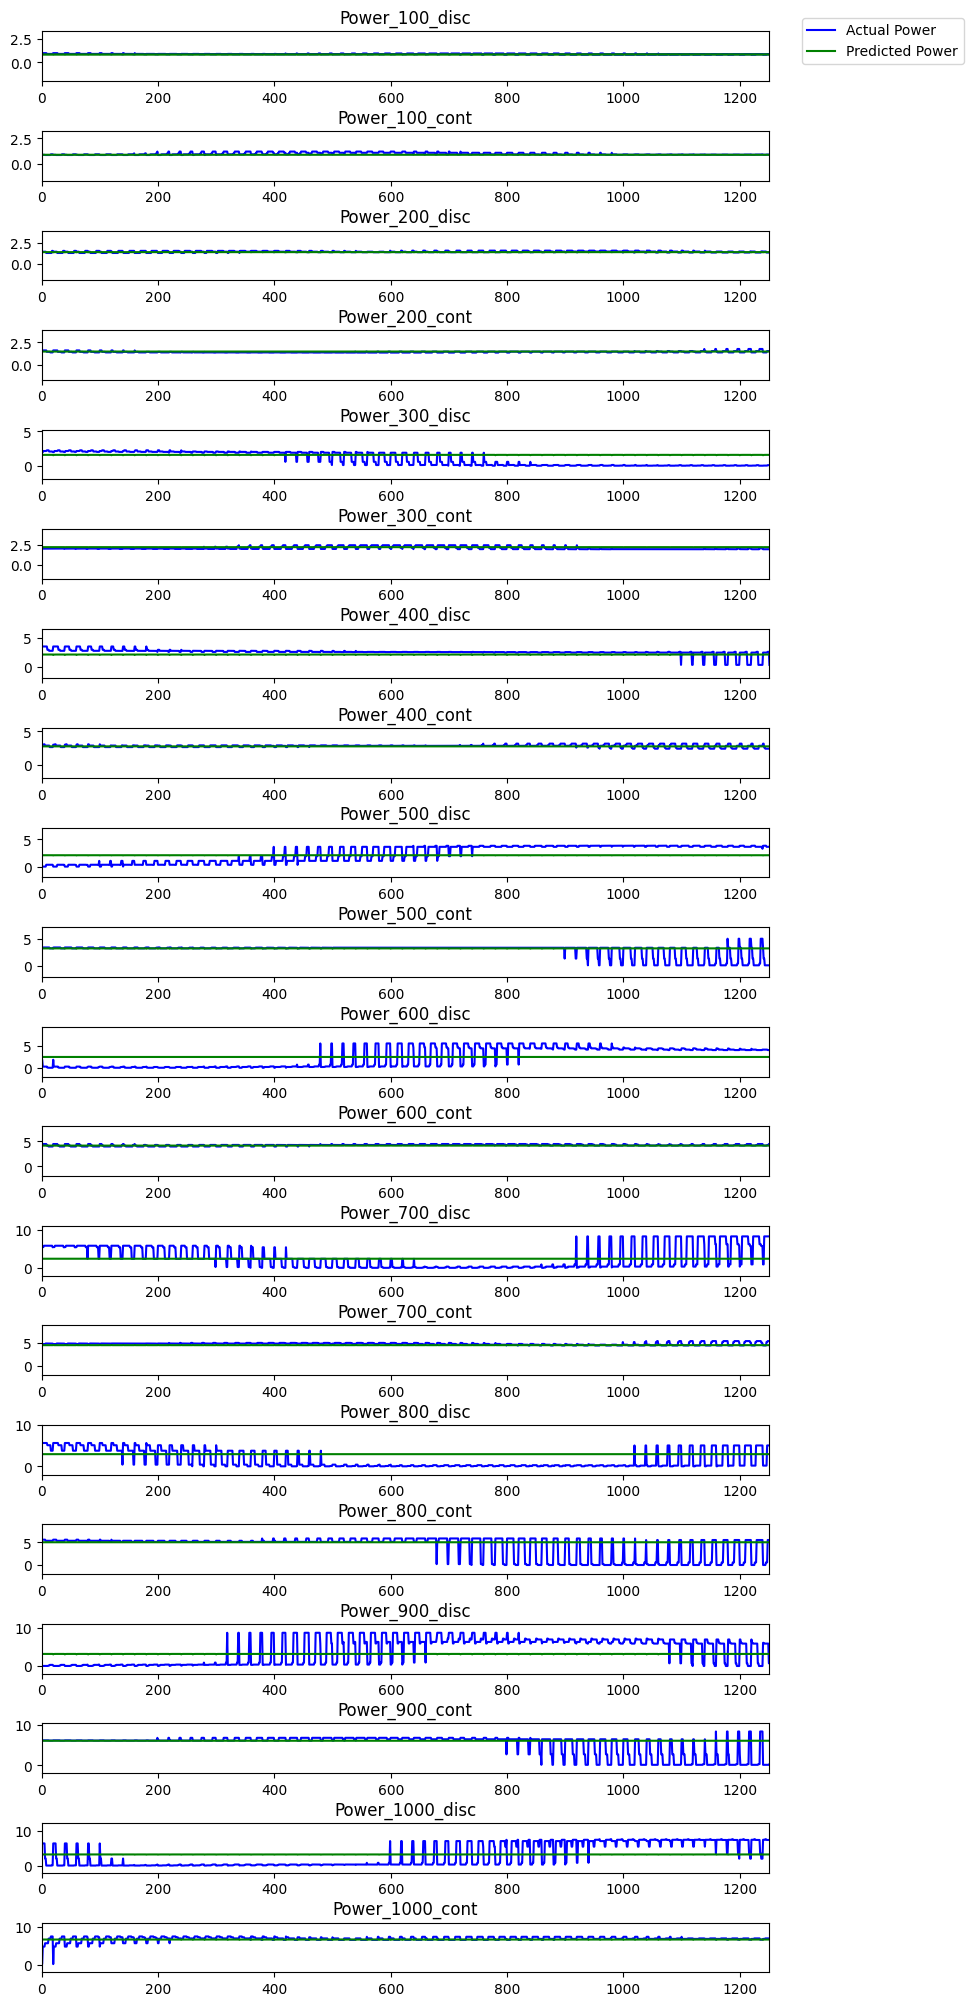

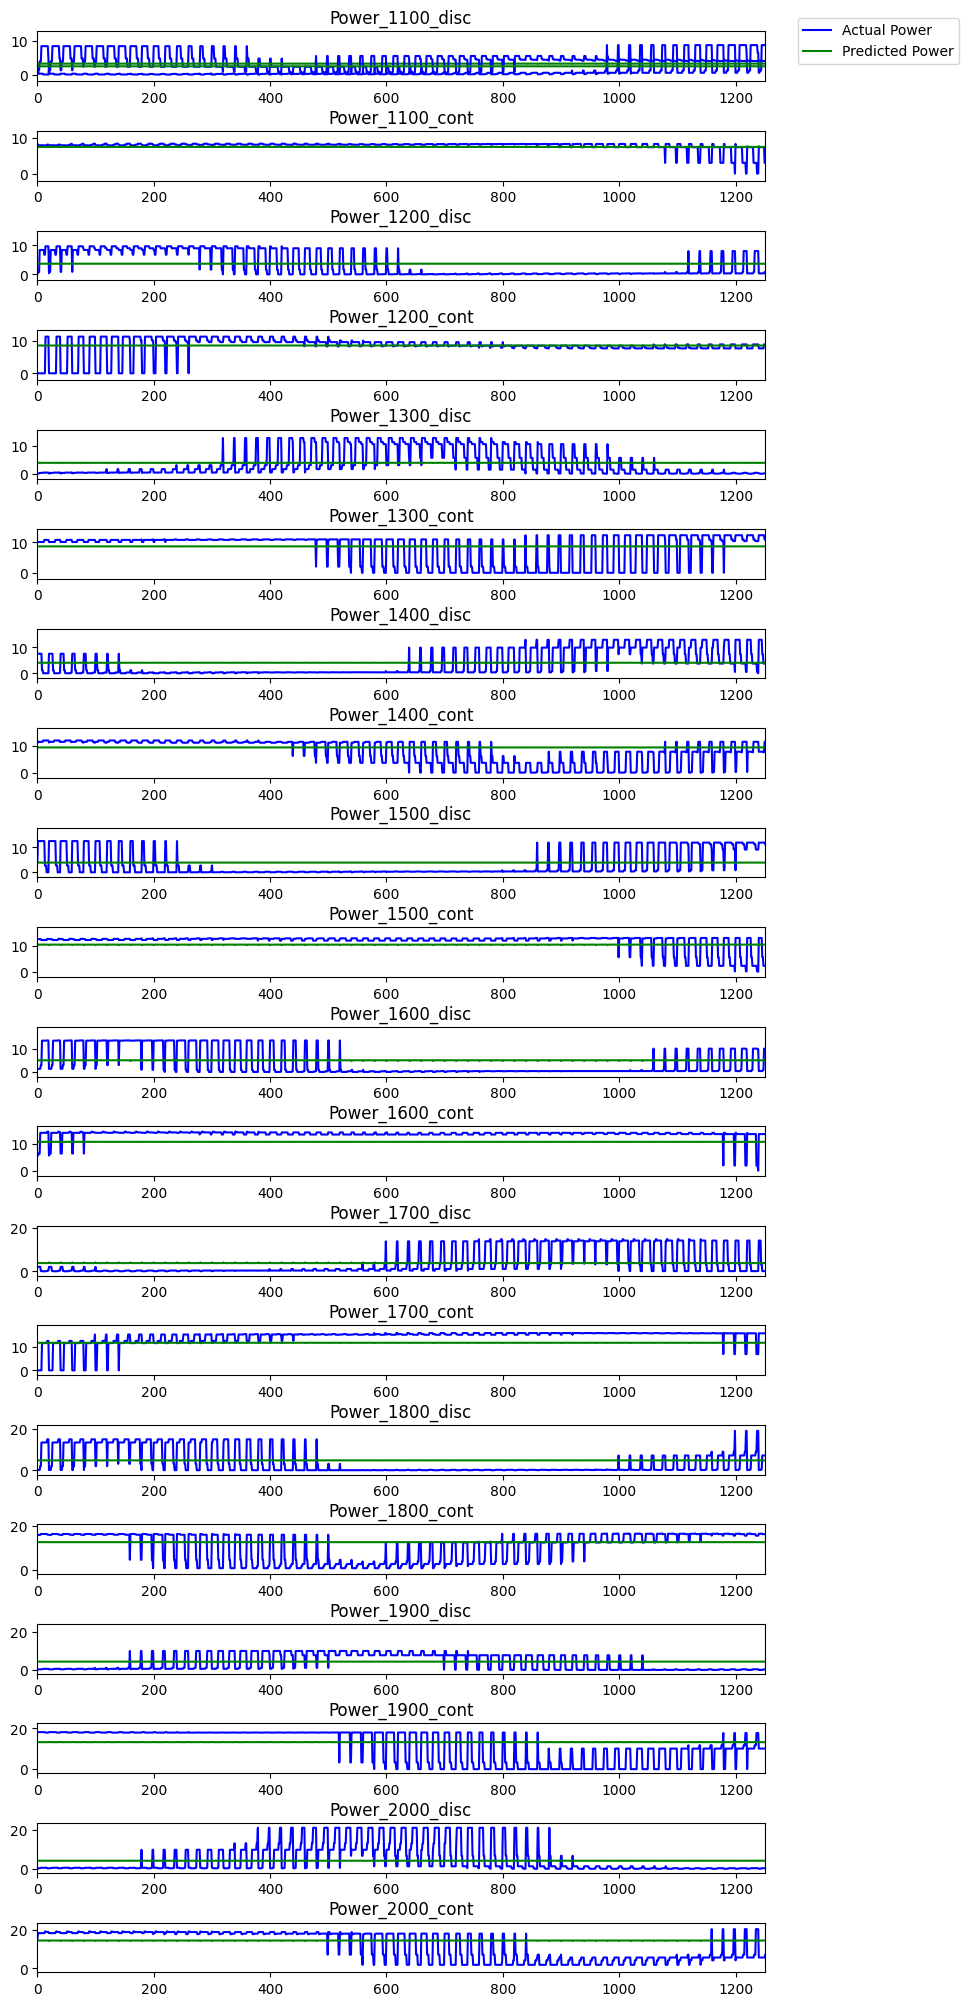

In [19]:
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[-1]))
yhat = model_enc_dec_cnn.predict(X_test)
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, yhat.shape[-1]))

fig1, ax1 = plt.subplots(20, 1, figsize=(8, 20))
fig1.tight_layout()
plt.subplots_adjust(hspace=1)

for i in range(0,20):
    ax1[i].plot(y_test_inverse[:, i], label='Actual Power', color='blue')
    ax1[i].plot(yhat_inverse[:, i], label='Predicted Power', color='green')
    ax1[i].set_ylim([min(min(y_test_inverse[:, i]), min(yhat_inverse[:, i]))-2, max(max(y_test_inverse[:, i]), max(yhat_inverse[:, i]))+2])
    ax1[i].set_title(power_list[i], y=1)
    ax1[i].set_xlim([0, 1250])

line1, = ax1[0].plot(y_test_inverse[:, 0], label='Actual Power', color='blue')
line2, = ax1[0].plot(yhat_inverse[:, 0], label='Predicted Power', color='green')
fig1.legend([line1, line2], ['Actual Power', 'Predicted Power'],loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

fig2, ax2 = plt.subplots(20, 1, figsize=(8, 20))
fig2.tight_layout()
plt.subplots_adjust(hspace=1)

for i in range(20,40):
    ax2[i-20].plot(y_test_inverse[:, i], label='Actual Power', color='blue')
    ax2[i-20].plot(yhat_inverse[:, i], label='Predicted Power', color='green')
    ax2[i-20].set_ylim([min(min(y_test_inverse[:, i]), min(yhat_inverse[:, i]))-2, max(max(y_test_inverse[:, i]), max(yhat_inverse[:, i]))+2])
    ax2[i-20].set_title(power_list[i], y=1)
    ax2[i-20].set_xlim([0, 1250])

line1, = ax2[0].plot(y_test_inverse[:, 10], label='Actual Power', color='blue')
line2, = ax2[0].plot(yhat_inverse[:, 10], label='Predicted Power', color='green')
fig2.legend([line1, line2], ['Actual Power', 'Predicted Power'],loc='upper left', bbox_to_anchor=(1, 1), ncol=1)


36/36 [==============================] - 7s 197ms/step


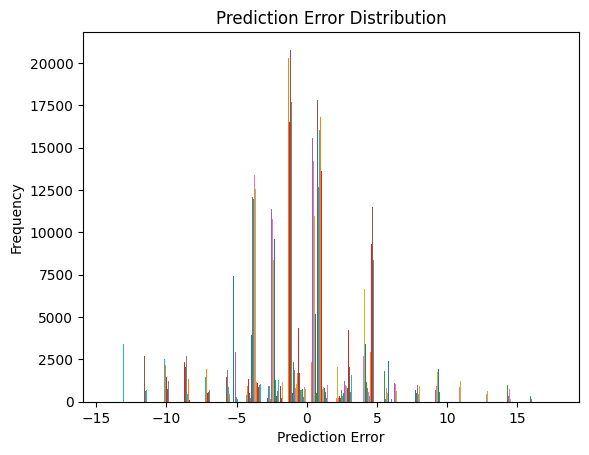

In [20]:
# predict the test set
y_test_pred = model_enc_dec_cnn.predict(X_test)

# reshape the predictions and test set
y_test_pred = y_test_pred.reshape(-1, y_test_pred.shape[-1])
y_test = y_test.reshape(-1, y_test.shape[-1])

#inverse the scaling
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)

# Prediction over distribution

# calculate the prediction error
error = y_test - y_test_pred

# plot the error distribution
plt.hist(error, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()
